In [1]:
import os
from uuid import uuid4
import hail as hl


spark_master_host = os.environ.get('SPARK_MASTER_HOST')
spark_master_port = os.environ.get('SPARK_MASTER_PORT')
localfs_path = os.environ.get('SCRATCH_LOCAL')

hl.init(
    master=f'spark://{spark_master_host}:{spark_master_port}',
    tmp_dir=os.path.join(localfs_path, 'hail-tmpdir'),
    default_reference='GRCh38',
    spark_conf={'spark.driver.memory': '40G', 'spark.executor.memory': '80G'},
    log=f'/net/archive/groups/plggneuromol/matzieb/hail-log/hail-log-{str(uuid4())}.log',
)

2022-08-08 11:59:56 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-08-08 11:59:57 WARN  SparkConf:69 - Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Running on Apache Spark version 3.1.2
SparkUI available at http://p0209.prometheus:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.79-f141af259254
LOGGING: writing to /net/archive/groups/plggneuromol/matzieb/hail-log/hail-log-359817e4-f16e-4c53-83fb-c98e429e2f8f.log


In [35]:
from hail.plot import show
from pprint import pprint
hl.plot.output_notebook()
 

Loading BokehJS ...

In [3]:
# Read vcf and reduce data
# mt = hl.import_vcf(
#     '/net/archive/groups/plggneuromol/matzieb/projects/imdik-zekanowski-sportwgs/data/prs-data/1kg-sportsmen-merged.vcf.gz',
#     array_elements_required=False,
#     force_bgz = True,
#     find_replace=('\tinf\t', '\t50\t')
# )
# # filter rows with p = 0.001
# mt = mt.sample_rows(0.001, seed = 42)

In [4]:
# mt.write('/net/archive/groups/plggneuromol/matzieb/projects/imdik-zekanowski-sportwgs/data/prs-data/sample-1kg-sportsmen-merged.mt', overwrite=True)

In [125]:
mt = hl.read_matrix_table('/net/archive/groups/plggneuromol/matzieb/projects/imdik-zekanowski-sportwgs/data/prs-data/sample-1kg-sportsmen-merged.mt')

In [126]:
mt.describe()
mt.count()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AF: array<float64>, 
        AC: array<int32>, 
        NS: int32, 
        AN: int32, 
        EAS_AF: array<float64>, 
        EUR_AF: array<float64>, 
        AFR_AF: array<float64>, 
        AMR_AF: array<float64>, 
        SAS_AF: array<float64>, 
        VT: array<str>, 
        EX_TARGET: bool, 
        DP: int32, 
        BaseQRankSum: float64, 
        END: int32, 
        ExcessHet: float64, 
        FS: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQRankSum: float64, 
        QD: float64, 
        RAW_MQandDP: array<int32>, 
        ReadPosRankSum: float64, 
   

(78280, 2650)

In [127]:
# read table with meta data
table = (hl.import_table('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/prs-data/1kg-sportsmen-pheno.tsv', impute=True)
         .key_by('sample'))

2022-08-08 13:11:55 Hail: INFO: Reading table to impute column types
2022-08-08 13:11:55 Hail: INFO: Finished type imputation
  Loading field 'sample' as type str (imputed)
  Loading field 'pop' as type str (imputed)
  Loading field 'super_pop' as type str (imputed)
  Loading field 'gender' as type str (imputed)
  Loading field 'group' as type str (imputed)


In [122]:
table.show()

,,,,
sample,pop,super_pop,gender,group
str,str,str,str,str
"""B102""","""speed""","""sportsmen""","""none""","""sportsman"""
"""B156""","""endurance""","""sportsmen""","""none""","""sportsman"""
"""B24""","""speed""","""sportsmen""","""none""","""sportsman"""
"""B338""","""endurance""","""sportsmen""","""none""","""sportsman"""
"""B382""","""endurance""","""sportsmen""","""none""","""sportsman"""
"""B399""","""speed""","""sportsmen""","""none""","""sportsman"""
"""B427""","""endurance""","""sportsmen""","""none""","""sportsman"""
"""B430""","""endurance""","""sportsmen""","""none""","""sportsman"""


In [129]:
# adding meta data into matrix table
mt = mt.annotate_cols(pheno = table[mt.s])

In [130]:
mt.aggregate_cols(hl.agg.counter(mt.pheno.super_pop))


frozendict({'AFR': 660, 'AMR': 347, 'EAS': 504, 'EUR': 503, 'SAS': 489, 'sportsmen': 102, None: 45})

In [131]:
mt = mt.filter_cols(mt.pheno.super_pop != "NA")

In [132]:
mt.aggregate_cols(hl.agg.counter(mt.pheno.super_pop))

frozendict({'AFR': 660, 'AMR': 347, 'EAS': 504, 'EUR': 503, 'SAS': 489, 'sportsmen': 102})

In [133]:
mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'pheno': struct {
        pop: str, 
        super_pop: str, 
        gender: str, 
        group: str
    }
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AF: array<float64>, 
        AC: array<int32>, 
        NS: int32, 
        AN: int32, 
        EAS_AF: array<float64>, 
        EUR_AF: array<float64>, 
        AFR_AF: array<float64>, 
        AMR_AF: array<float64>, 
        SAS_AF: array<float64>, 
        VT: array<str>, 
        EX_TARGET: bool, 
        DP: int32, 
        BaseQRankSum: float64, 
        END: int32, 
        ExcessHet: float64, 
        FS: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQR

In [93]:
# execute pca on matrix table
eigenvalues, pcs, _ = hl.hwe_normalized_pca(mt.GT)

2022-08-08 12:46:10 Hail: INFO: hwe_normalize: found 76496 variants after filtering out monomorphic sites.
2022-08-08 12:46:12 Hail: INFO: pca: running PCA with 10 components...24) / 327]


In [134]:
print(eigenvalues)
pcs.show(5, width=100)
mt = mt.annotate_cols(scores = pcs[mt.s].scores)

[46.95772179217532, 15.030188722578318, 5.991234608757411, 4.372042668284096, 4.013099499014388, 3.049046793432452, 2.552746022867229, 2.488035851583296, 2.47624153759411, 2.4449301358272466]


,
s,scores
str,array<float64>
"""B102""","[-7.88e-02,-8.84e-02,-3.56e-02,3.93e-02,-1.90e-03,4.79e-05,3.59e-05,5.45e-04,-1.02e-03,-8.07e-04]"
"""B156""","[-7.40e-02,-8.76e-02,-3.60e-02,3.89e-02,-3.86e-03,3.55e-04,8.07e-04,5.61e-04,-1.99e-03,3.61e-04]"
"""B24""","[-7.41e-02,-1.01e-01,-3.74e-02,2.87e-02,-1.20e-03,1.14e-03,7.56e-04,7.88e-04,-1.24e-03,-1.42e-03]"
"""B338""","[-7.60e-02,-8.89e-02,-3.08e-02,4.57e-02,-3.30e-03,-1.09e-03,-2.73e-05,1.08e-03,-4.26e-03,8.13e-05]"
"""B382""","[-7.79e-02,-9.22e-02,-3.27e-02,3.71e-02,-3.74e-03,5.13e-04,-6.88e-04,2.89e-03,-1.25e-03,-8.99e-04]"


In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.models import CategoricalColorMapper
mapper = CategoricalColorMapper(palette=["red", "yellow", "green", "blue", "purple", "orange"], factors=["AFR", "AMR", "EAS", "EUR", "SAS", "sportsmen"])
palette = dict(sporstmen="orange", AFR="red", AMR="yellow", EAS="green", EUR="blue", SAS="purple")
sns.set_style('darkgrid')

In [136]:
# plot for pca
p = hl.plot.scatter(mt.scores[0],
                    mt.scores[1],
                    label=mt.pheno.super_pop,
                    colors=mapper, 
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

2022-08-08 13:31:34 Hail: INFO: Coerced sorted dataset


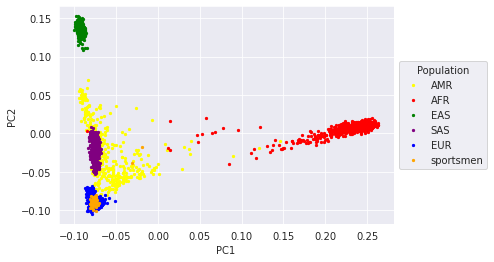

In [171]:
pca_df = mt.cols().flatten().to_pandas(flatten = True).rename(columns={'pheno.super_pop': 'super_pop'})
pca_df[['PC1','PC2', 'PC3','PC4', 'PC5', 
        'PC6', 'PC7', 'PC8', 'PC9', 'PC10']] = pd.DataFrame(pca_df.scores.tolist(), 
                                                            index = pca_df.index)

palette = dict(sportsmen="orange", AFR="red", AMR="yellow", EAS="green", EUR="blue", SAS="purple")
colors = ["yellow", "red", "green", "purple", "blue", "orange"]
population = ["AMR", "AFR", "EAS", "SAS", "EUR", "sportsmen"]

# create plot for pc1 and pc2
for col, pop in zip(colors, population):
    plt.scatter(pca_df[pca_df.super_pop == pop]['PC1'],
                pca_df[pca_df.super_pop == pop]['PC2'], 
                color = col, s = 5)
plt.legend(population, loc = 'center left', bbox_to_anchor=(1, 0.5), title = "Population")
plt.xlabel('PC1')
plt.ylabel('PC2')
# plt.show()

plt.savefig("/net/archive/groups/plggneuromol/matzieb/projects/imdik-zekanowski-sportwgs/results/prs-plots/pca.svg", 
            facecolor='white', bbox_inches='tight')

In [145]:
# calculate meadian absolute deviation for PC1 i PC2
mad_pc1 = hl.median(
    hl.abs(
        hl.median(
            mt.filter_cols(mt.pheno.super_pop == "sportsmen")
            .scores[0].collect())-mt.filter_cols(mt.pheno.super_pop=="sportsmen")
        .scores[0]
    ).collect())
mad_pc2 =  hl.median(
    hl.abs(
        hl.median(
            mt.filter_cols(mt.pheno.super_pop == "sportsmen")
            .scores[1].collect())-mt.filter_cols(mt.pheno.super_pop=="sportsmen")
        .scores[1]
    ).collect())

In [146]:
mad_pc1.show()
mad_pc2.show()

""
""
float64
1.65e-03


""
""
float64
2.24e-03


In [148]:
# filter data near MAD for sportsmen
mt_filter = mt.filter_cols(
    (mt.scores[0] > hl.median(mt.filter_cols(mt.pheno.super_pop == "sportsmen").scores[0].collect())-6*mad_pc1) &
    (mt.scores[0] < hl.median(mt.filter_cols(mt.pheno.super_pop == "sportsmen").scores[0].collect())+6*mad_pc1) & 
    (mt.scores[1] > hl.median(mt.filter_cols(mt.pheno.super_pop == "sportsmen").scores[1].collect())-6*mad_pc2) &
    (mt.scores[1] < hl.median(mt.filter_cols(mt.pheno.super_pop == "sportsmen").scores[1].collect())+6*mad_pc2) &
    (mt.pheno.super_pop != "AMR")
)

In [149]:
mt_filter.count()

(78280, 550)

In [150]:
mt_filter.aggregate_cols(hl.agg.counter(mt_filter.pheno.super_pop))

frozendict({'EUR': 450, 'sportsmen': 100})

In [151]:
p = hl.plot.scatter(mt_filter.scores[0],
                    mt_filter.scores[1],
                    label=mt_filter.pheno.super_pop,
                    colors=mapper,
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

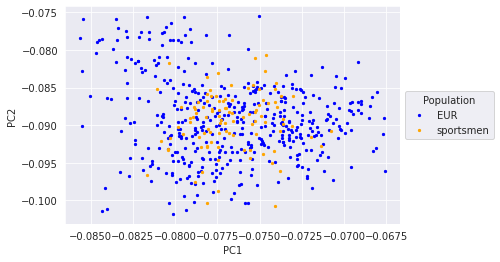

In [170]:
pca_filter_df = mt_filter.cols().flatten().to_pandas(flatten = True).rename(columns={'pheno.super_pop': 'super_pop'})
pca_filter_df[['PC1','PC2', 'PC3','PC4', 'PC5', 
                      'PC6', 'PC7', 'PC8', 'PC9', 'PC10']] = pd.DataFrame(pca_filter_df.scores.tolist(), 
                                                                          index = pca_filter_df.index)

colors = ["blue", "orange"]
population = ["EUR", "sportsmen"]

# create plot for pc1 and pc2
for col, pop in zip(colors, population):
    plt.scatter(pca_filter_df[pca_filter_df.super_pop == pop]['PC1'],
                pca_filter_df[pca_filter_df.super_pop == pop]['PC2'], 
                color = col, s = 5)
plt.legend(population, loc = 'center left', bbox_to_anchor=(1, 0.5), title = "Population")
plt.xlabel('PC1')
plt.ylabel('PC2')
# plt.show()

plt.savefig("/net/archive/groups/plggneuromol/matzieb/projects/imdik-zekanowski-sportwgs/results/prs-plots/pca-filter.svg", 
            facecolor='white', bbox_inches='tight')

In [154]:
eigenvalues_filter, pcs_filter, _ = hl.hwe_normalized_pca(mt_filter.GT)

2022-08-08 13:17:19 Hail: INFO: hwe_normalize: found 22744 variants after filtering out monomorphic sites.
2022-08-08 13:17:22 Hail: INFO: pca: running PCA with 10 components...24) / 327]


In [155]:
print(eigenvalues_filter)
pcs_filter.show(5, width=100)
mt_second_pca = mt_filter.annotate_cols(scores = pcs_filter[mt_filter.s].scores)

[2.8931867873053942, 2.014405975817246, 1.710930782157045, 1.6607276439772871, 1.6420614758280974, 1.62879883417021, 1.6223625694248305, 1.6158915940633063, 1.6082058266623966, 1.590486810036136]


,
s,scores
str,array<float64>
"""B102""","[-1.62e-01,-3.53e-02,-8.02e-03,-8.70e-03,5.85e-03,2.89e-03,-1.13e-02,6.67e-03,-2.70e-03,9.47e-03]"
"""B156""","[-1.30e-01,-3.89e-02,-2.88e-03,-9.33e-03,-2.50e-03,7.83e-03,5.48e-03,2.94e-03,-1.16e-03,6.65e-03]"
"""B24""","[-1.43e-01,-4.61e-02,-7.98e-03,-1.07e-02,-8.63e-03,7.85e-03,4.38e-03,-2.32e-03,3.73e-03,-8.30e-03]"
"""B338""","[-1.62e-01,-4.09e-02,-6.82e-03,-1.49e-03,-6.36e-03,2.14e-03,-4.59e-03,4.07e-03,5.00e-03,-3.41e-03]"
"""B382""","[-1.50e-01,-3.63e-02,4.20e-03,-5.20e-03,-3.00e-03,-7.08e-03,-4.41e-04,-1.71e-03,-8.25e-04,2.11e-03]"


In [156]:
plot_second_pca = hl.plot.scatter(mt_second_pca.scores[1],
                                    mt_second_pca.scores[2],
                                    label=mt_second_pca.pheno.super_pop,
                                    colors=mapper,
                                    title='PCA', xlabel='PC2', ylabel='PC3')
show(plot_second_pca)

2022-08-08 13:31:20 Hail: INFO: Coerced sorted dataset


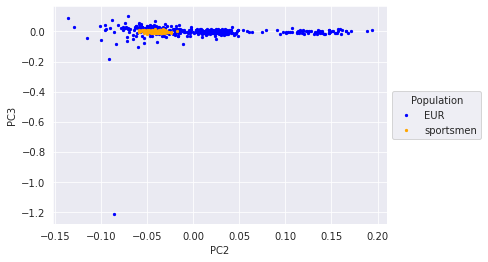

In [169]:
second_pca_df = mt_second_pca.cols().flatten().to_pandas(flatten = True).rename(columns={'pheno.super_pop': 'super_pop'})
second_pca_df[['PC1','PC2', 'PC3','PC4', 'PC5', 
                      'PC6', 'PC7', 'PC8', 'PC9', 'PC10']] = pd.DataFrame(second_pca_df.scores.tolist(), 
                                                                          index = second_pca_df.index)

# create plot for pc2 and pc3
for col, pop in zip(colors, population):
    plt.scatter(second_pca_df[second_pca_df.super_pop == pop]['PC2'],
                second_pca_df[second_pca_df.super_pop == pop]['PC3'], 
                color = col, s = 5)
plt.legend(population, loc = 'center left', bbox_to_anchor=(1, 0.5), title = "Population")
plt.xlabel('PC2')
plt.ylabel('PC3')
# plt.show()


plt.savefig("/net/archive/groups/plggneuromol/matzieb/projects/imdik-zekanowski-sportwgs/results/prs-plots/second-pca.svg", 
            facecolor='white', bbox_inches='tight')

In [159]:
mad_second_pc2 = hl.median(
    hl.abs(
        hl.median(
            mt_second_pca.filter_cols(mt_second_pca.pheno.super_pop == "sportsmen")
            .scores[1].collect())-mt_second_pca.filter_cols(mt_second_pca.pheno.super_pop=="sportsmen")
        .scores[1]
    ).collect())
mad_second_pc3 =  hl.median(
    hl.abs(
        hl.median(
            mt_second_pca.filter_cols(mt_second_pca.pheno.super_pop == "sportsmen")
            .scores[2].collect())-mt_second_pca.filter_cols(mt_second_pca.pheno.super_pop=="sportsmen")
        .scores[2]
    ).collect())

In [160]:
mad_second_pc2.show()
mad_second_pc3.show()

""
""
float64
5.58e-03


""
""
float64
4.30e-03


In [161]:
# filter data near MAD for sportsmen
mt_second_filter = mt_second_pca.filter_cols(
    (mt_second_pca.scores[1] > hl.median(mt_second_pca.filter_cols(mt_second_pca.pheno.super_pop=="sportsmen").scores[1].collect()) - 5*mad_second_pc2) &
    (mt_second_pca.scores[1] < hl.median(mt_second_pca.filter_cols(mt_second_pca.pheno.super_pop=="sportsmen").scores[1].collect()) + 5*mad_second_pc2) &
    (mt_second_pca.scores[2] > hl.median(mt_second_pca.filter_cols(mt_second_pca.pheno.super_pop=="sportsmen").scores[2].collect()) - 5*mad_second_pc3) &
    (mt_second_pca.scores[2] < hl.median(mt_second_pca.filter_cols(mt_second_pca.pheno.super_pop=="sportsmen").scores[2].collect()) + 5*mad_second_pc3)
)


In [162]:
mt_second_filter.count()

(78280, 198)

In [163]:
mt_second_filter.aggregate_cols(hl.agg.counter(mt_second_filter.pheno.super_pop))

frozendict({'EUR': 98, 'sportsmen': 100})

In [164]:
plot_second_filter = hl.plot.scatter(mt_second_filter.scores[1],
                                     mt_second_filter.scores[2],
                                     label=mt_second_filter.pheno.super_pop,
                                     colors=mapper,
                                     title='PCA', xlabel='PC2', ylabel='PC3')

show(plot_second_filter)


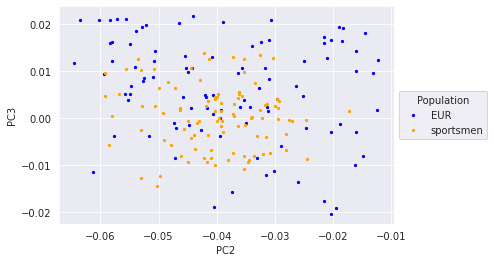

In [168]:
pca_second_filter_df = mt_second_filter.cols().flatten().to_pandas(flatten = True).rename(columns={'pheno.super_pop': 'super_pop'})
pca_second_filter_df[['PC1','PC2', 'PC3','PC4', 'PC5', 
                      'PC6', 'PC7', 'PC8', 'PC9', 'PC10']] = pd.DataFrame(pca_second_filter_df.scores.tolist(), 
                                                                          index = pca_second_filter_df.index)

# create plot for pc2 and pc3
for col, pop in zip(colors, population):
    plt.scatter(pca_second_filter_df[pca_second_filter_df.super_pop == pop]['PC2'],
                pca_second_filter_df[pca_second_filter_df.super_pop == pop]['PC3'], 
                color = col, s = 5)
plt.legend(population, loc = 'center left', bbox_to_anchor=(1, 0.5), title = "Population")
plt.xlabel('PC2')
plt.ylabel('PC3')
# plt.show()

plt.savefig("/net/archive/groups/plggneuromol/matzieb/projects/imdik-zekanowski-sportwgs/results/prs-plots/pca-second-filter.svg", 
            facecolor='white', bbox_inches='tight')

In [167]:
# save metadata with sportsmen and control to tsv file
sportsmen_control_pheno = mt_second_filter.cols()

sportsmen_control_pheno = sportsmen_control_pheno.annotate(group = sportsmen_control_pheno.pheno.group.replace("1kg", "control"))

sportsmen_control_pheno = sportsmen_control_pheno.drop(sportsmen_control_pheno.scores).flatten()

sportsmen_control_pheno = sportsmen_control_pheno.drop(sportsmen_control_pheno['pheno.group']).rename({
    's':'sample',
    'pheno.pop': 'pop', 
    'pheno.super_pop': 'super_pop', 
    'pheno.gender':'gender'}).export(
    '/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/prs-data/sportsmen-control-pheno.tsv',
    header=True
)

2022-08-08 13:22:24 Hail: INFO: Coerced sorted dataset
2022-08-08 13:22:25 Hail: INFO: merging 16 files totalling 6.6K...
2022-08-08 13:22:25 Hail: INFO: while writing:
    /net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/prs-data/sportsmen-control-pheno.tsv
  merge time: 16.086ms
